In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import base64
import numpy as np
import seaborn as sns

from IPython.core.display import display, HTML
from sklearn.cluster import KMeans
from datetime import datetime

In [2]:
plt.style.use(['dark_background'])
plt.suptitle('figure title', color='w')

Text(0.5,0.98,'figure title')

<Figure size 432x288 with 0 Axes>

In [3]:
def cluster_impute(dataframe, variables):
    region_vals = dataframe.groupby(['region_clusters'])[variables].mean()
    for i in range(0, len(np.unique(dataframe['region_clusters']))):
        mask = (dataframe[variables] == 0) & (dataframe.region_clusters == i)
        dataframe.loc[mask, variables] = int(region_vals[i])
#         dataframe.loc[dataframe.region_clusters == i, variables] = int(region_vals[i])

In [4]:
def dummy_encode(dataframe, drop_var):
    categorical_columns = dataframe.columns[dataframe.dtypes == 'object']
    for c in categorical_columns:
        dummy_set = pd.get_dummies(dataframe[c], prefix=c)
        dataframe = pd.concat([dataframe, dummy_set], axis=1)
        if drop_var:
            dataframe.drop(c, axis=1, inplace=True)
    return dataframe

#### Cleaning Steps Taken:
#### Removal of rows with longitude value of 0 - UPDATE: impute with mean value instead of dropping
#### Imputation of population, construction_year, and gps_height based on the variable's cluster mean
#### Imputation of boolean variables permit and public_meeting, NaN values were set to False
#### Created year and month standalone columns
#### For the categorical variables bin anythin less than 10% of the column values into the "other" category
#### Code based on examples from https://zlatankr.github.io/posts/2017/01/23/pump-it-up
#### Import Datasets

In [5]:
train_data = pd.read_csv('data/training_values.csv', header=0, sep=',')
test_data = pd.read_csv('data/test_values.csv', header=0, sep=',')

##### Print of column headers for reference

In [6]:
print(len(train_data))
print(len(train_data.columns))
print(train_data.columns)

59400
40
Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')


#### Add region clusters for imputation

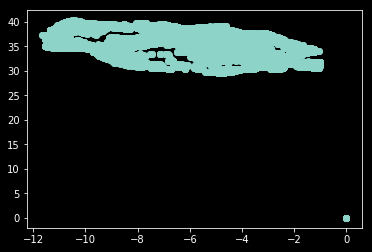

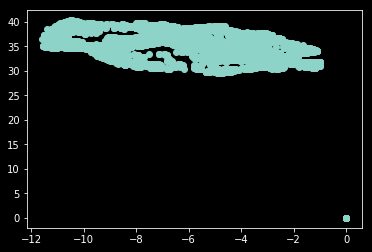

In [7]:
plt.scatter(train_data['latitude'], train_data['longitude'])
plt.show()
plt.scatter(test_data['latitude'], test_data['longitude'])
plt.show()

#### Impute 0 longitude values

In [8]:
train_data.loc[train_data['longitude'] == 0, 'latitude'] = np.mean(train_data.latitude)
train_data.loc[train_data['longitude'] == 0, 'longitude'] = np.mean(train_data.longitude)

In [9]:
test_data.loc[test_data['longitude'] == 0, 'latitude'] = np.mean(test_data.latitude)
test_data.loc[test_data['longitude'] == 0, 'longitude'] = np.mean(test_data.longitude)

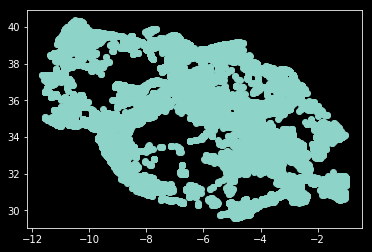

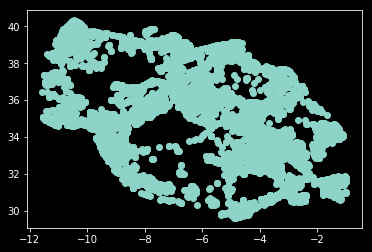

In [10]:
lat_lon_dataframe = train_data[['latitude', 'longitude']].copy()
# lat_lon_dataframe = lat_lon_dataframe[lat_lon_dataframe.ne(0).all(axis=1)]
plt.scatter(lat_lon_dataframe['latitude'], lat_lon_dataframe['longitude'])
plt.show()
lat_lon_dataframe_test = test_data[['latitude', 'longitude']].copy()
plt.scatter(lat_lon_dataframe_test['latitude'], lat_lon_dataframe_test['longitude'])
plt.show()

In [11]:
kmeans_model = KMeans(n_clusters=6, random_state=1).fit(lat_lon_dataframe)
cluster_labels = kmeans_model.predict(lat_lon_dataframe)
lat_lon_dataframe['cluster_values'] = cluster_labels

In [12]:
kmeans_test = KMeans(n_clusters=6, random_state=1).fit(lat_lon_dataframe_test)
cluster_labels_test = kmeans_model.predict(lat_lon_dataframe_test)
lat_lon_dataframe_test['cluster_values'] = cluster_labels_test

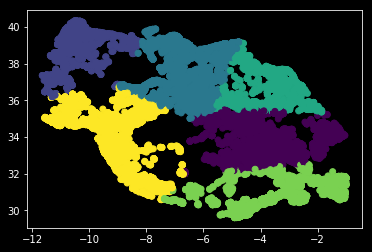

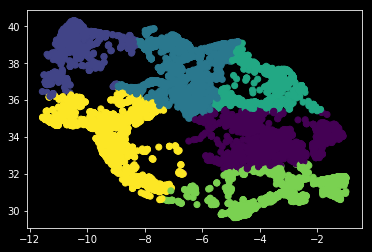

In [13]:
plt.scatter(lat_lon_dataframe['latitude'], lat_lon_dataframe['longitude'], c=lat_lon_dataframe['cluster_values'])
plt.show()
plt.scatter(lat_lon_dataframe_test['latitude'], lat_lon_dataframe_test['longitude'], c=lat_lon_dataframe_test['cluster_values'])
plt.show()

#### Add the cluster assignments back to the training dataset

In [14]:
train_data['region_clusters'] = cluster_labels
test_data['region_clusters'] = cluster_labels_test

#### Verify the new cluster assignments in the training data

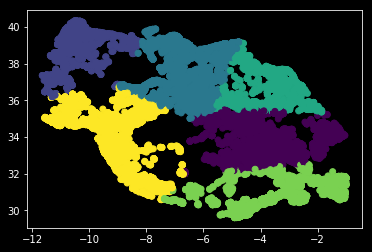

In [15]:
plt.scatter(train_data['latitude'], train_data['longitude'], c=train_data['region_clusters'])
plt.show()

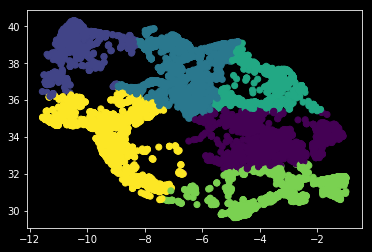

In [16]:
plt.scatter(test_data['latitude'], test_data['longitude'], c=test_data['region_clusters'])
plt.show()

#### Impute population and gps_height

In [17]:
print(train_data['population'].astype(bool).sum(axis=0))
print(train_data['gps_height'].astype(bool).sum(axis=0))

38019
38962


In [18]:
cluster_impute(train_data, 'population')
cluster_impute(train_data, 'gps_height')

In [19]:
cluster_impute(test_data, 'population')
cluster_impute(test_data, 'gps_height')

In [20]:
print(train_data['population'].astype(bool).sum(axis=0))
print(train_data['gps_height'].astype(bool).sum(axis=0))

59400
59400


#### Impute construction year

In [21]:
np.unique(train_data.construction_year[train_data.region_clusters == 0], return_counts=True)

(array([   0, 1960, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1972,
        1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
        1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
        1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
        2006, 2007, 2008, 2009, 2010, 2011, 2012], dtype=int64),
 array([8583,   58,    1,   16,    2,    1,    8,   12,    4,  108,   56,
          23,   95,   37,   20,    7,  128,   12,  180,    5,   55,   41,
           4,   65,   48,   35,   32,   43,  303,   62,   86,   99,  107,
         151,  193,  132,  234,  138,  349,   48,   87,  160,  138,   87,
         206,  124,  258,  224,  299,  271,  189], dtype=int64))

In [22]:
median_construction_year = train_data.groupby(['region_clusters'])['construction_year'].median()
print(median_construction_year)

region_clusters
0       0
1    1992
2    1999
3    2000
4       0
5    1985
Name: construction_year, dtype: int64


In [23]:
for i in range(0, len(np.unique(train_data['region_clusters']))):
    mask_1 = (train_data['construction_year'] == 0) & (train_data.region_clusters == i)
    if i == 0:
        train_data.loc[mask_1, 'construction_year'] = 2000
    elif i == 4:
        train_data.loc[mask_1, 'construction_year'] = 2009
    else:
        train_data.loc[mask_1, 'construction_year'] = int(median_construction_year[i])

In [24]:
np.unique(train_data.construction_year[train_data.region_clusters == 0], return_counts=True)

(array([1960, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1972, 1973,
        1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
        1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
        1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010, 2011, 2012], dtype=int64),
 array([  58,    1,   16,    2,    1,    8,   12,    4,  108,   56,   23,
          95,   37,   20,    7,  128,   12,  180,    5,   55,   41,    4,
          65,   48,   35,   32,   43,  303,   62,   86,   99,  107,  151,
         193,  132,  234,  138, 8932,   48,   87,  160,  138,   87,  206,
         124,  258,  224,  299,  271,  189], dtype=int64))

In [25]:
median_construction_year_test = test_data.groupby(['region_clusters'])['construction_year'].median()
print(median_construction_year_test)

region_clusters
0       0
1    1994
2    2000
3    2000
4       0
5    1986
Name: construction_year, dtype: int64


In [26]:
for i in range(0, len(np.unique(test_data['region_clusters']))):
    mask_1_test = (test_data['construction_year'] == 0) & (test_data.region_clusters == i)
    if i == 0:
        test_data.loc[mask_1_test, 'construction_year'] = 2000
    elif i == 4:
        test_data.loc[mask_1_test, 'construction_year'] = 2009
    else:
        test_data.loc[mask_1_test, 'construction_year'] = int(median_construction_year_test[i])

#### Date formatting

In [27]:
train_data['date_recorded'] = pd.to_datetime(train_data['date_recorded'])
test_data['date_recorded'] = pd.to_datetime(test_data['date_recorded'])

In [28]:
train_data['construction_year'] = pd.to_datetime(train_data['construction_year'])
test_data['construction_year'] = pd.to_datetime(test_data['construction_year'])

In [29]:
print(train_data['date_recorded'].head())

0   2011-03-14
1   2013-03-06
2   2013-02-25
3   2013-01-28
4   2011-07-13
Name: date_recorded, dtype: datetime64[ns]


In [30]:
train_data['year_recorded'], train_data['month_recorded'] = train_data['date_recorded'].dt.year, train_data['date_recorded'].dt.month
test_data['year_recorded'], test_data['month_recorded'] = test_data['date_recorded'].dt.year, test_data['date_recorded'].dt.month

In [31]:
print(train_data['year_recorded'].head())

0    2011
1    2013
2    2013
3    2013
4    2011
Name: year_recorded, dtype: int64


In [32]:
print(train_data['month_recorded'].head())

0    3
1    3
2    2
3    1
4    7
Name: month_recorded, dtype: int64


#### Add a variable to calculate the age of the pump

In [33]:
print(train_data.date_recorded.dtype)
print(train_data.construction_year.dtype)

datetime64[ns]
datetime64[ns]


In [34]:
train_data['pump_age_days'] = (train_data.date_recorded - train_data.construction_year).dt.days
test_data['pump_age_days'] = (test_data.date_recorded - test_data.construction_year).dt.days

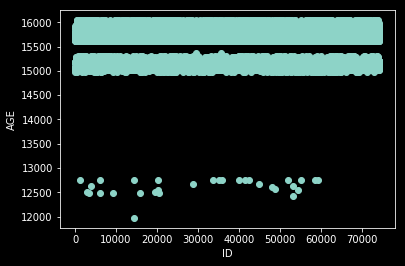

In [35]:
plt.scatter(train_data.id, train_data.pump_age_days)
plt.xlabel('ID')
plt.ylabel('AGE')
plt.show()

#### Research amount_tsh

In [36]:
test_row = train_data.loc[train_data['amount_tsh'] != 0]

In [37]:
len(np.unique(test_row.amount_tsh, return_counts=True)[0])

97

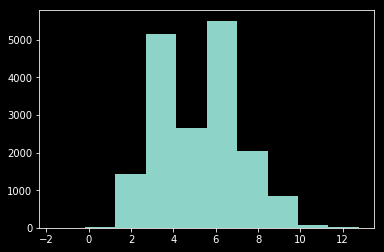

In [38]:
plt.hist(np.log(test_row.amount_tsh))
plt.show()

In [39]:
print(len(train_data.amount_tsh))
print(len(test_row.amount_tsh))

59400
17761


#### Research GPS Height

0    1390
1    1399
2     686
3     263
4     535
Name: gps_height, dtype: int64


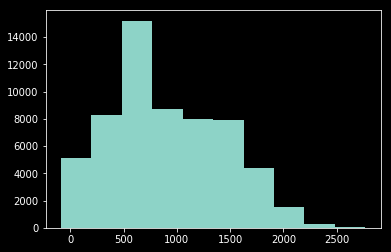

In [40]:
print(train_data.gps_height.head())
plt.hist(train_data.gps_height)
plt.show()

#### Possibly use frequency
##### Code based on https://github.com/drivendataorg/pump-it-up/tree/master/mrbeer

In [41]:
val_counts = train_data['gps_height'].value_counts()
for i, val in enumerate(train_data['gps_height'].values):
    print(i)
    print(int(val_counts.at[val]))

0
26
1
36
2
11
3
26
4
4356
5
2317
6
8553
7
8553
8
8553
9
4356
10
30
11
18
12
8553
13
30
14
8553
15
21
16
30
17
19
18
34
19
13
20
1
21
8553
22
29
23
7
24
21
25
34
26
8
27
4356
28
24
29
30
30
2317
31
9
32
30
33
22
34
11
35
33
36
4669
37
608
38
7
39
30
40
14
41
1
42
16
43
23
44
18
45
8553
46
11
47
4669
48
6
49
8
50
20
51
25
52
4669
53
8553
54
4356
55
6
56
21
57
31
58
30
59
4356
60
13
61
17
62
12
63
26
64
44
65
29
66
13
67
4356
68
32
69
27
70
51
71
4669
72
4669
73
37
74
16
75
4356
76
9
77
12
78
9
79
4356
80
2
81
9
82
32
83
8553
84
26
85
4356
86
22
87
4356
88
11
89
2317
90
20
91
12
92
36
93
25
94
4356
95
32
96
32
97
8553
98
25
99
8553
100
18
101
21
102
33
103
13
104
23
105
12
106
8553
107
4356
108
29
109
4669
110
46
111
32
112
4356
113
4669
114
2317
115
4356
116
13
117
21
118
26
119
30
120
5
121
4356
122
4356
123
36
124
4669
125
4356
126
30
127
8
128
8553
129
8553
130
4356
131
30
132
4669
133
8553
134
36
135
8
136
4669
137
26
138
4356
139
4356
140
4669
141
16
142
8553
143
25
144
31
145
41
1

#### Impute True/False Variables (permit and public_meeting)

In [42]:
print(sum(pd.isna(train_data.permit)))
print(sum(pd.isna(train_data.public_meeting)))

3056
3334


In [43]:
train_data['permit'] = train_data['permit'].fillna(False)
train_data['public_meeting'] = train_data['public_meeting'].fillna(False)
test_data['permit'] = test_data['permit'].fillna(False)
test_data['public_meeting'] = test_data['public_meeting'].fillna(False)

In [44]:
print(sum(pd.isna(train_data.permit)))
print(sum(pd.isna(train_data.public_meeting)))

0
0


#### Remove duplicate variables

In [45]:
drop_list = ['extraction_type_group', 'extraction_type_class', 'payment_type', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']

In [46]:
train_data.drop(drop_list, axis=1, inplace=True)
test_data.drop(drop_list, axis=1, inplace=True)

In [47]:
print(train_data.columns)
print(test_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'management', 'management_group', 'payment',
       'water_quality', 'quantity', 'source', 'region_clusters',
       'year_recorded', 'month_recorded', 'pump_age_days'],
      dtype='object')
Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'management', 'management_group', 'payment',
 

#### Spot check categorical variables

In [48]:
tmp1 = pd.value_counts(train_data['water_quality'])
tmp2 = (tmp1/tmp1.sum() * 100)
print(tmp2)

soft                  85.552189
salty                  8.175084
unknown                3.158249
milky                  1.353535
coloured               0.824916
salty abandoned        0.570707
fluoride               0.336700
fluoride abandoned     0.028620
Name: water_quality, dtype: float64


#### Summarize low frequency categorical variables
##### Any categorical variable value that makes up less than 3% of the unique vales for the variable will be binned into the "other" category

##### Example based on https://stackoverflow.com/questions/47418299/python-combining-low-frequency-factors-category-counts

In [49]:
categorical_columns = train_data.columns[train_data.dtypes == 'object']
for c in categorical_columns:
    series = pd.value_counts(train_data[c])
    mask = (series/series.sum() * 100).lt(3)
    train_data[c] = np.where(train_data[c].isin(series[mask].index), 'other', train_data[c])
#     print((series/series.sum() * 100).lt(10))

In [50]:
categorical_columns_test = test_data.columns[test_data.dtypes == 'object']
for ct in categorical_columns:
    series_test = pd.value_counts(test_data[ct])
    mask_test = (series_test/series_test.sum() * 100).lt(3)
    test_data[ct] = np.where(test_data[ct].isin(series_test[mask_test].index), 'other', test_data[ct])

In [51]:
for i in train_data.columns[train_data.dtypes == 'object']:
    print(pd.value_counts(train_data[i]))

other                     41365
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Name: funder, dtype: int64
other         36518
DWE           17402
Government     1825
Name: installer, dtype: int64
other    55837
none      3563
Name: wpt_name, dtype: int64
Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64
other    59029
Name: subvillage, dtype: int64
other          5664
Iringa         5294
Shinyanga      4982
Mbeya          4639
Kilimanjaro    4379
Morogoro       4006
Arusha         3350
Kagera         3316
Mwanza         3102
Kigoma         2816
Ruvuma         2640
Pwani          2635
Tanga          2547
Dodoma         2201
Singida        2093
Mara           1969
Tabora 

In [52]:
tmp1 = pd.value_counts(train_data['water_quality'])
tmp2 = (tmp1/tmp1.sum() * 100)
print(tmp2)

soft       85.552189
salty       8.175084
unknown     3.158249
other       3.114478
Name: water_quality, dtype: float64


#### For funder and installer if there are any blank values add them as 'other'

In [53]:
train_data['funder'].fillna('other', inplace=True)
train_data['installer'].fillna('other', inplace=True)
test_data['funder'].fillna('other', inplace=True)
test_data['installer'].fillna('other', inplace=True)

#### Dummy encode the categorical variables

In [54]:
train_data = dummy_encode(train_data, True)
test_data = dummy_encode(test_data, True)

In [55]:
print(len(train_data.columns))
print(train_data.columns)
print(len(test_data.columns))
print(test_data.columns)

104
Index(['id', 'amount_tsh', 'date_recorded', 'gps_height', 'longitude',
       'latitude', 'num_private', 'region_code', 'district_code', 'population',
       ...
       'quantity_enough', 'quantity_insufficient', 'quantity_other',
       'quantity_seasonal', 'source_machine dbh', 'source_other',
       'source_rainwater harvesting', 'source_river', 'source_shallow well',
       'source_spring'],
      dtype='object', length=104)
104
Index(['id', 'amount_tsh', 'date_recorded', 'gps_height', 'longitude',
       'latitude', 'num_private', 'region_code', 'district_code', 'population',
       ...
       'quantity_enough', 'quantity_insufficient', 'quantity_other',
       'quantity_seasonal', 'source_machine dbh', 'source_other',
       'source_rainwater harvesting', 'source_river', 'source_shallow well',
       'source_spring'],
      dtype='object', length=104)


In [56]:
variable_correlation = train_data.corr()

In [57]:
print(np.abs(variable_correlation) > .5)

                                  id  amount_tsh  gps_height  longitude  \
id                              True       False       False      False   
amount_tsh                     False        True       False      False   
gps_height                     False       False        True      False   
longitude                      False       False       False       True   
latitude                       False       False       False      False   
num_private                    False       False       False      False   
region_code                    False       False       False      False   
district_code                  False       False       False      False   
population                     False       False       False      False   
public_meeting                 False       False       False      False   
permit                         False       False       False      False   
region_clusters                False       False       False      False   
year_recorded            

#### Check variable correlation

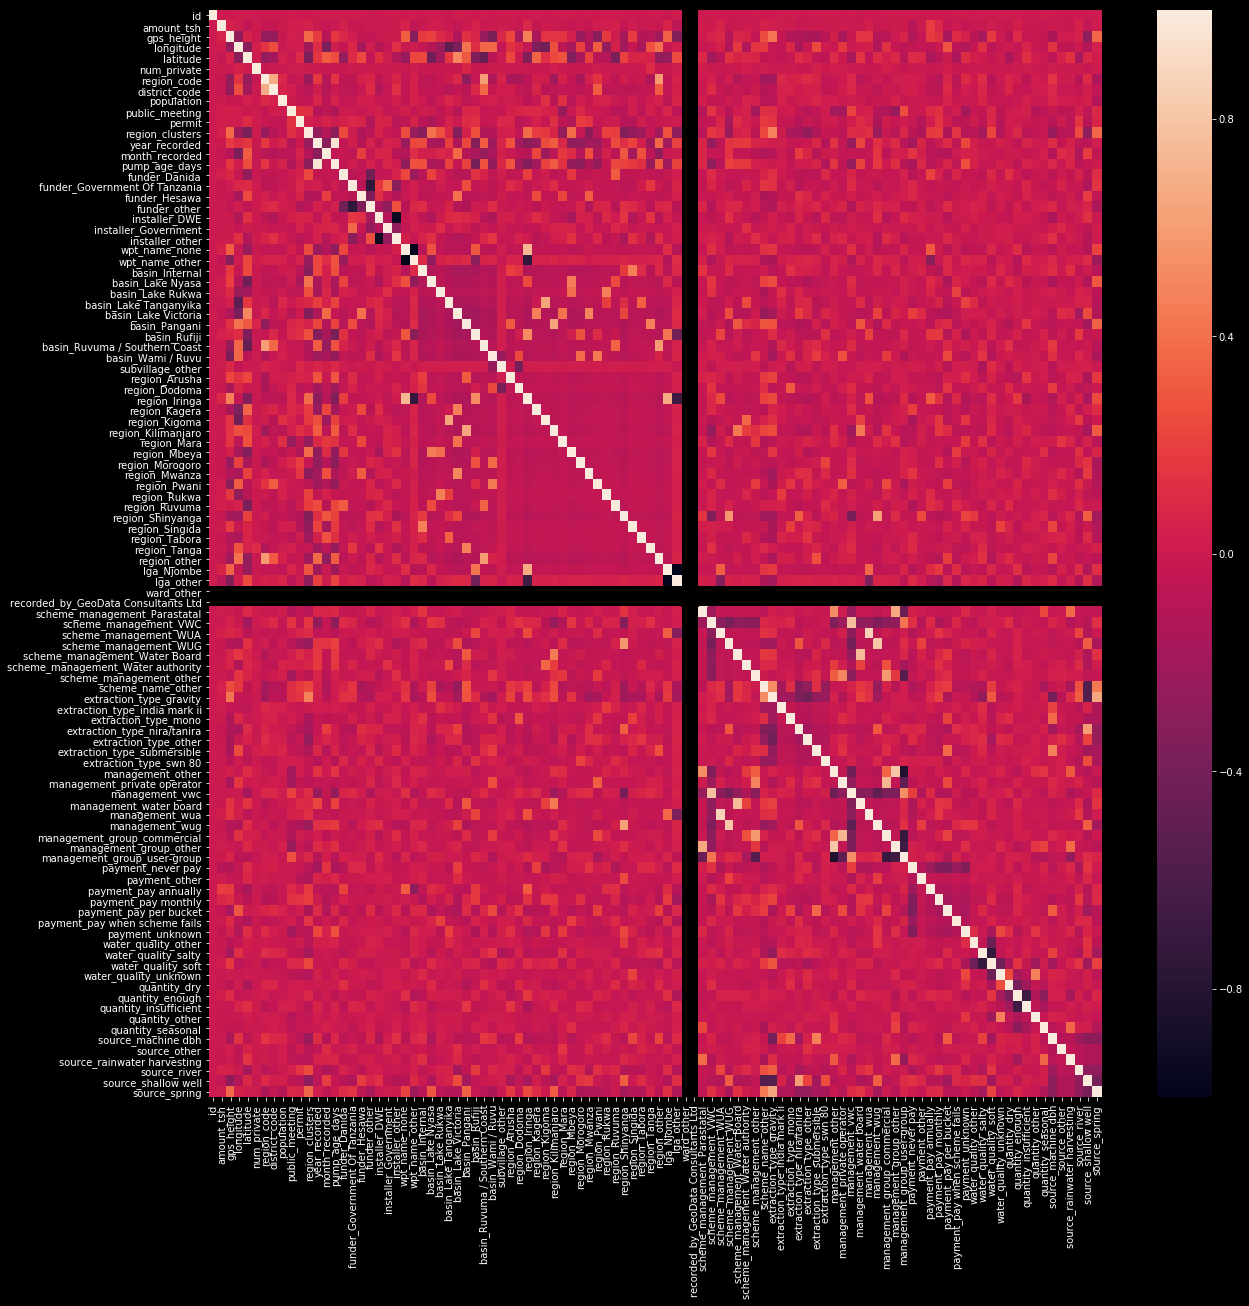

In [58]:
plt.subplots(figsize=(20,20))
var_cor = sns.heatmap(variable_correlation, xticklabels=variable_correlation.columns, yticklabels=variable_correlation.columns, annot=False)

In [59]:
var_cor.figure.savefig('images/variable_correlations.png')

In [60]:
variable_correlation.to_csv('data/variable_correlations.csv', sep=",")

#### Report for percentage of other

In [61]:
train_data.to_csv("data/train_dataframe_full.csv", sep=",", header=True)
test_data.to_csv("data/test_dataframe_full.csv", sep=",", header=True)